In [103]:
from scipy.special import sph_harm as sph
import astropy.io.fits as pf
from math import sqrt, pi
import healpy as hp
import numpy as np
import time
NSIDE = 8
print(f"For NSIDE = {NSIDE}, numPix = {hp.nside2npix(NSIDE)}, Nmax = int(1.5*sqrt(numPix)) = {int(1.5*sqrt(hp.nside2npix(NSIDE)))}")
%matplotlib notebook

For NSIDE = 8, numPix = 768, Nmax = int(1.5*sqrt(numPix)) = 41


In [93]:
def make_map(theta, phi, data, NSIDE):
    """
    Makes healPy map given the map values on grid points and the grid coordinates.
    
    ==========================================================
    Inputs: (theta, phi, data, NSIDE)
    ----------------------------------------------------------
    theta - coordinate 1
    phi   - coordiante 2
    data  - value of map at [coordinate 1, coordinate 2]
    NSIDE - the NSIDE for the output healPy map
    ==========================================================
    Outputs: (map, mask, theta, phi)
    ----------------------------------------------------------
    map   - the healPy map 
    mask  - mask which contains information about missing data
    theta - coordinate 1 (healPy format)
    phi   - coordinate 2 (healPy format)
    ==========================================================
    
    """
    # checking if the input data is compatible
    assert len(theta) == len(phi) == len(data)
    
    _numPix = hp.nside2npix(NSIDE) # number of healPy pixels
    
    # creating map, mask, theta, phi, count arrays
    e1map = np.full(numPix, hp.UNSEEN, dtype=np.float)
    existance = np.full(numPix, False, dtype=np.bool)
    counts = np.ones(numPix, dtype=np.int) # used for averaging pixel data
    thetaNew = np.zeros(numPix)
    phiNew = np.zeros(numPix)
    
    for i,k in enumerate(data):
        _index = hp.ang2pix(NSIDE, theta[i], phi[i])
        thetaNew[index], phiNew[index] = hp.pix2ang(NSIDE, index)
        if not existance[index]:
            e1map[index] = 0
            counts[index] = 0
            existance[index] = True
        e1map[index] += k
        counts[index] += 1
    print(f"Making healPy maps -- Complete")
    return e1map/counts, existance, thetaNew, phiNew

In [94]:
def restructure(ellArr, emmArr, lmax, coefs):
    """
    Restructures the alms into the format compatible with pleg
    
    i.e. newCoefs[0] corresponds to ell = 0, emm = 0
         newCoefs[1] corresponds to ell = 1, emm = 0
         newCoefs[2] corresponds to ell = 1, emm = 1
         newCoefs[3] corresponds to ell = 2, emm = 0
         newCoefs[4] corresponds to ell = 2, emm = 1 
         newCoefs[5] corresponds to ell = 2, emm = 2
         ..... and so on
    
    ===========================================================
    Inputs: (ellArr, emmArr, lmax, coefs)
    -----------------------------------------------------------
    ellArr  - array with ell corresponding to alms
    emmArr  - array with m corresponding to alms
    lmax    - maximum value of ell
    coefs   - alms
    ===========================================================
    Outputs: (newCoefs)
    -----------------------------------------------------------
    newCoefs - new alms in the format compatible with pleg
    ===========================================================
    
    """
    count = 0
    newCoefs = np.zeros(coefs.shape[0], dtype=complex)
    for ell in range(lmax):
        for emm in range(ell+1): 
            index = np.where( (ellArr==ell) * (emmArr==emm) )[0][0]
            newCoefs[count] = coefs[index]
            count += 1
    return newCoefs

### Creating a synthetic map
We first create a synthetic map where $f(\theta, \phi) = \sum_{l=0}^{lmax} \sum_{m=-l}^l r_{lm} Y_{lm}(\theta, \phi)$, where $r_{lm}$ is a random coefficient. Two such maps are created. One with half disk and one with full disk data. These synthetic maps are band limited, by design. Synthetic maps have only $m \ge 0$ features.

For testing rotation of spherical harmonics, we create a maps for each of $\hat{r}, \hat{\theta}, \hat{\phi}$ components. The $\hat{r}$ map contains a bunch of randomly generated values $\to$ This is denoted by map_r. The $\hat{\theta}$ map contains meridional circulation. We do this by using $ v_{20}, v_{40} $ components $\to$ map_t. The $\hat{\phi}$ map contains differential rotation. We generate this by using $ w_{10}, w_{30} $ components $\to$ map_p.

In [95]:
# parameters for the synthetic map
lmaxSynth = 8 # maximum ell for the radial map
maxNum = int((lmaxSynth+1)*(lmaxSynth+2)/2)
almSynth = np.zeros(maxNum)
ellSynth = np.zeros(maxNum)

Nmax = 40
theta = np.linspace(0, pi - 1e-4, Nmax).reshape(Nmax, 1)
phi = np.linspace(-pi/2 + 1e-4, pi/2 - 1e-4, Nmax).reshape(1, Nmax)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta) * np.ones(phi.shape)
PHIROT = np.arctan2(z, y)
THETAROT = np.arcsin(np.sqrt( y**2 + z**2 ))
PHI, THETA = np.meshgrid(phi, theta)

count = 0
for ell in range(lmaxSynth):
    for emm in range(ell+1):
        if ell==0 and emm==0:
            almSynth[count] = (np.random.rand() - 0.5)*ell
            ellSynth[count] = ell
            map0 = almSynth[count]*sph(emm, ell, phi, theta)
            count += 1
        else:
            almSynth[count] = (np.random.rand() - 0.5)*ell
            ellSynth[count] = ell
            map0 += almSynth[count]*sph(emm, ell, phi, theta)
            count += 1
# giving the synthetic maps some rotation+MC features
#map0 += 2000*sph(0, 1, phi, theta) + 200*sph(0, 3, phi, theta) + 20*sph(0, 5, phi, theta) +  150*sph(0, 2, phi, theta) + 15*sph(0, 60, phi, theta)
print("r-component -- complete")

map1 = sph(0, 2, phi, theta) + 0.2*sph(0, 4, phi, theta) #map for theta component
map2 = sph(0, 1, phi, theta) + 0.15*sph(0, 3, phi, theta) #map for phi component
print("t-component -- complete")
print("p-component -- complete")

ps0 = np.zeros(lmaxSynth)
for ell in range(lmaxSynth):
    maskEll = ellSynth==ell
    ps0[ell] = (abs(almSynth[maskEll])**2).sum()*2/(2*ell+1)
ellSynthArr = np.arange(lmaxSynth)

r-component -- complete
t-component -- complete
p-component -- complete


Range of THETA = (0.0, 3.141492653589793)
Range of PHI = (-1.5706963267948966, 1.5706963267948966)
Range of THETAROT = (0.056914286214843894, 1.5707963267948966)
Range of PHIROT = (-3.1013671065479875, 3.101267106547489)
count = 0


<IPython.core.display.Javascript object>


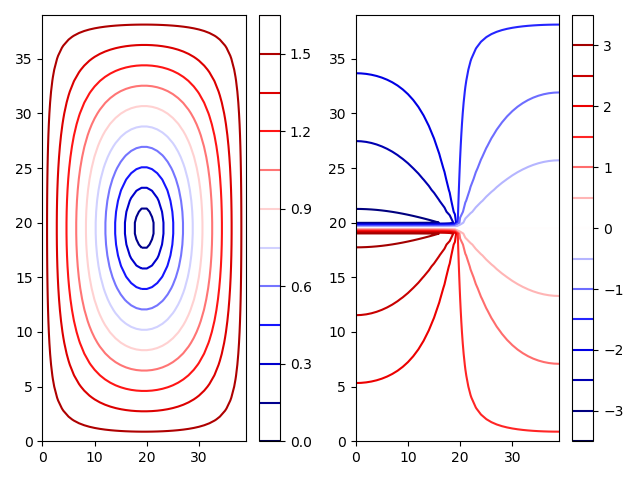

In [96]:
print(f"Range of THETA = ({THETA.min()}, {THETA.max()})")
print(f"Range of PHI = ({PHI.min()}, {PHI.max()})")
print(f"Range of THETAROT = ({THETAROT.min()}, {THETAROT.max()})")
print(f"Range of PHIROT = ({PHIROT.min()}, {PHIROT.max()})")
tempmask = np.sqrt( y**2 + z**2 ) > 1
print(f"count = {tempmask.sum()}")
del tempmask
plt.figure()
plt.subplot(121)
im = plt.contour(THETAROT, 12, cmap='seismic')
plt.colorbar(im)

plt.subplot(122)
im = plt.contour(PHIROT, 12, cmap='seismic')
plt.colorbar(im)

plt.tight_layout()
plt.show()

In [97]:
def pow_alm(ipmap):
    power = hp.sphtfunc.anafast(ipmap)
    alm = hp.sphtfunc.map2alm(ipmap)
    return power, alm

# Making the healPy maps
map_r, mask_r, theta, phi = make_map(THETA.flatten(), PHI.flatten(), map0.flatten(), NSIDE)
map_t, mask_t, theta, phi = make_map(THETA.flatten(), PHI.flatten(), map1.flatten(), NSIDE)
map_p, mask_p, theta, phi = make_map(THETA.flatten(), PHI.flatten(), map2.flatten(), NSIDE)
map_rRot, mask_rRot, thetaRot, phiRot = make_map(THETAROT.flatten(), PHIROT.flatten(), map0.flatten(), NSIDE)
map_tRot, mask_tRot, thetaRot, phiRot = make_map(THETAROT.flatten(), PHIROT.flatten(), map1.flatten(), NSIDE)
map_pRot, mask_pRot, thetaRot, phiRot = make_map(THETAROT.flatten(), PHIROT.flatten(), map2.flatten(), NSIDE)

/home/samarth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: ComplexWarning: Casting complex values to real discards the imaginary part


Making healPy maps -- Complete
Making healPy maps -- Complete
Making healPy maps -- Complete
Making healPy maps -- Complete
Making healPy maps -- Complete
Making healPy maps -- Complete


<IPython.core.display.Javascript object>


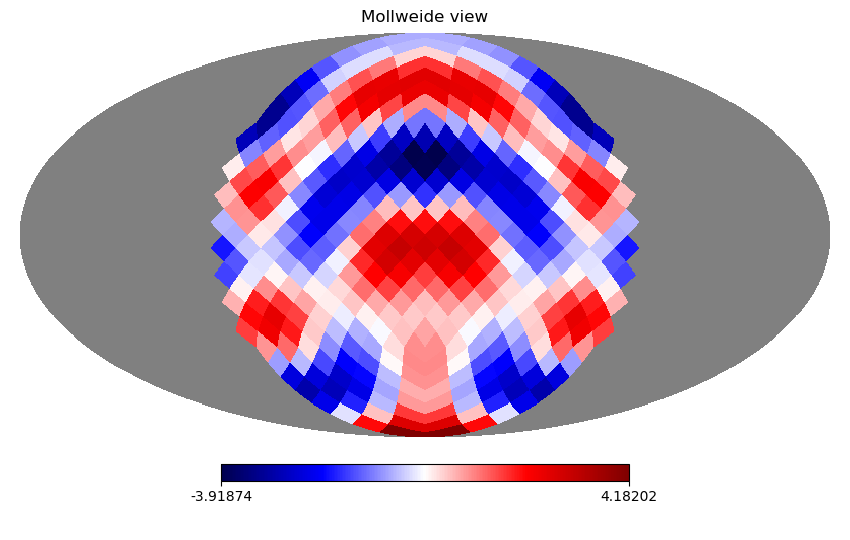

Making healPy maps -- Complete


/home/samarth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: ComplexWarning: Casting complex values to real discards the imaginary part


<IPython.core.display.Javascript object>


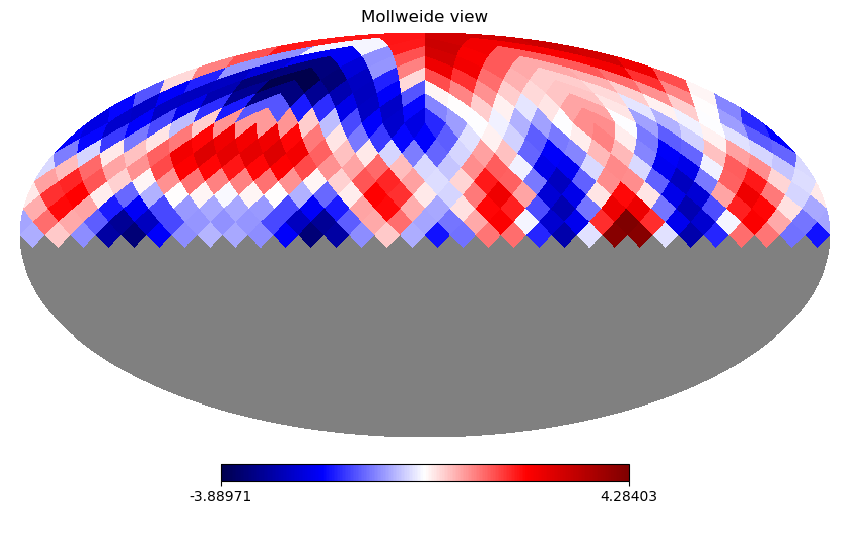

<IPython.core.display.Javascript object>


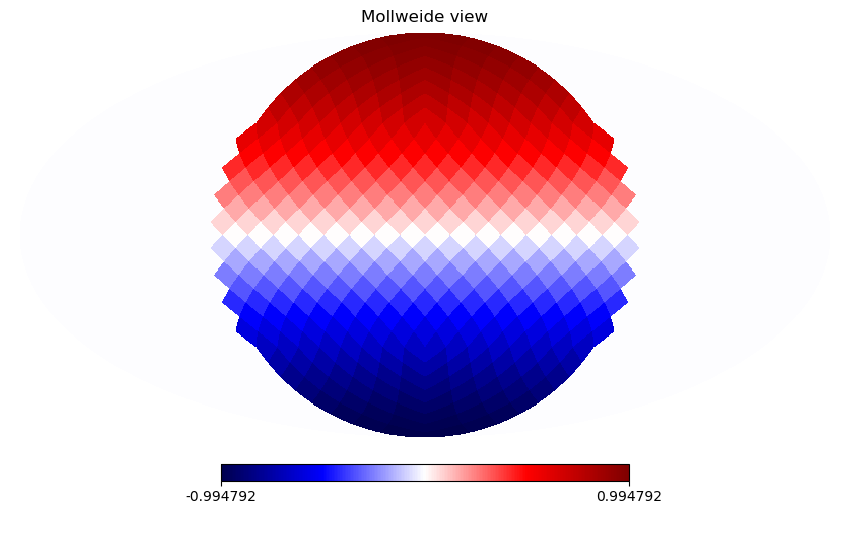

In [99]:
hp.mollview(map_r, cmap='seismic')
map_rRot, mask_rRot, thetaRot, phiRot = make_map(THETAROT.flatten(), PHIROT.flatten(), map0.flatten(), NSIDE)
hp.mollview(map_rRot, cmap='seismic')

# Computing the alms using healPy functions
power_r, alm_r = pow_alm(map_r)
power_t, alm_t = pow_alm(map_t)
power_p, alm_p = pow_alm(map_p)

# Computing the alms-spin1 using healPy functions
nside = NSIDE
npix = hp.nside2npix(nside)
ipix = np.arange(npix)
theta_p1, phi_p1 = hp.pix2ang(nside, ipix)

lr_p1 = np.cos(theta_p1)
lt_p1 = -np.sin(theta_p1)
lr_p1[~mask_r] = 0.0
lt_p1[~mask_r] = 0.0

hp.mollview(lr_p1, cmap='seismic')

In [83]:
theta.shape

(12288,)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


<IPython.core.display.Javascript object>


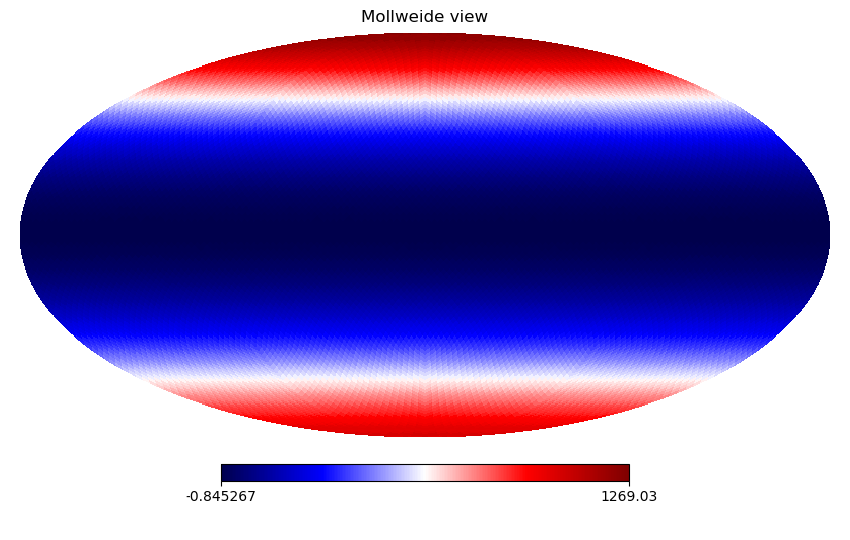

<IPython.core.display.Javascript object>


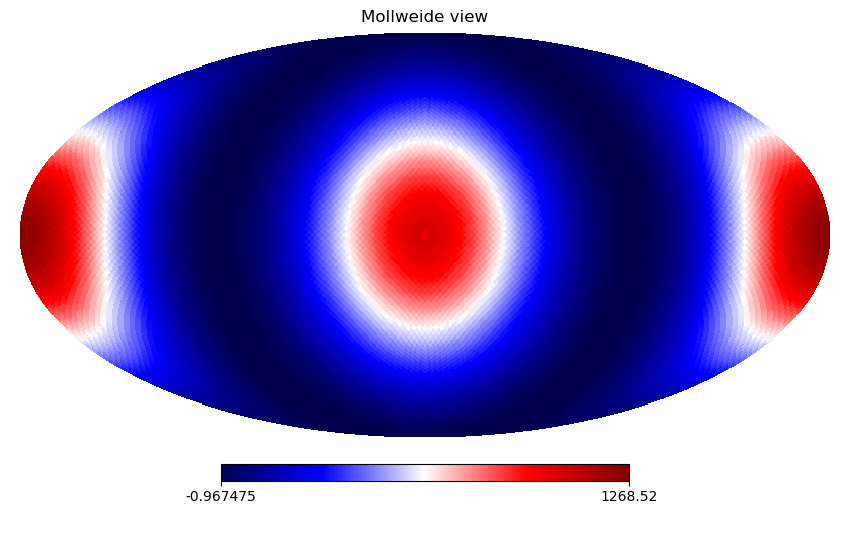

In [86]:
nside = NSIDE
npix = hp.nside2npix(nside)
ipix = np.arange(npix)
#theta, phi = hp.pix2ang(nside, ipix)

lr = np.cos(theta)
lt = -np.sin(theta)

apod = 1.0#/(1 + np.exp(35*(thetaMapRot - np.pi/2.3)))
map_0 = mapFull * lr * apod
map_p1 = - mapFull * lt / sqrt(2) * apod
map_m1 = - mapFull * lt / sqrt(2) * apod
#map_trans = [(map_p1 + map_m1)/2, -1j*(map_p1 - map_m1)/2]
map_trans = [map_p1, 0.0*map_p1]
map_0[~maskFull] = hp.UNSEEN
map_trans[0][~maskFull] = 0.0#hp.UNSEEN
map_trans[1][~maskFull] = 0.0#hp.UNSEEN
alm_r = hp.map2alm(map_0)
alm_pm = hp.map2alm_spin(map_trans, 1)
alm_v, alm_w = alm_pm[0], alm_pm[1]
alm_p = alm_pm[0]
alm_m = alm_pm[1]
alm_vRot = -alm_p
alm_wRot = -1j*alm_m


alm2r = alm_r.copy()
alm2p = alm_p.copy()
alm2m = alm_m.copy()
hp.rotate_alm(alm2r, psi=0.0, theta=-pi/2, phi=0.0)
#hp.rotate_alm(alm2r, psi=0.0, theta=pi/2, phi=0.0)
hp.rotate_alm(alm2p, psi=0.0, theta=pi/2, phi=0.0)
hp.rotate_alm(alm2m, psi=0.0, theta=pi/2, phi=0.0)
map2 = hp.alm2map(alm2r, 32)
hp.mollview(map_0, cmap='seismic')
hp.mollview(map2, cmap='seismic')